In [2]:
import os
import warnings
import cv2
import keras
import matplotlib.pyplot as plt
import matplotlib.style as style
import numpy as np
import pandas as pd
from PIL import Image
from keras import models, layers, optimizers
from keras.applications import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras.preprocessing import image as image_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import pdb

% matplotlib inline
style.use('seaborn-whitegrid')
warnings.filterwarnings(action='once')

UsageError: Line magic function `%` not found.


In [118]:
def process_image(path):
    img = Image.open(path)
    img = np.array(img)
    return img

def process_data(X_data, y_data):
    X_data = np.array(X_data, dtype = 'float32')
    X_data = np.stack((X_data,)*3, axis=-1)
    X_data /= 255
    y_data = np.array(y_data)
    return X_data, y_data

def walk_file_tree(relative_paths, cat_num, max_count):
    count_per_dir_dict = {}
    num_dirs_in_excess = 0
    count_remaining = max_count
    X_data = []
    for path in relative_paths:
        for directory, subdirectories, files in os.walk(path):
            num_files = len(files)
        count_per_dir_dict[path] = num_files
        if num_files <= max_count / len(dirs):
            count_remaining -= len(files)
        else:
            num_dirs_in_excess += 1
    for path in relative_paths:
        X_data_temp = []
        for directory, subdirectories, files in os.walk(path):
            for file in files:
                file_path = os.path.join(directory, file)
                X_data_temp.append(process_image(file_path))
        # if appropriate amount, process X_data as usual
        if count_per_dir_dict[path] <= max_count / len(dirs):
            X_data.extend(X_data_temp) 
        else: 
            count_for_dir = int(np.ceil(count_remaining/num_dirs_in_excess))
            random_indices = np.random.choice(len(X_data_temp), size=count_for_dir, replace=False)
            X_data_temp = [X_data_temp[i] for i in random_indices]
            X_data.extend(X_data_temp) 
    y_data = [cat_num for i in range(len(X_data))]
    X_data, y_data = process_data(X_data, y_data)
    return X_data, y_data

class Data(object):
    def __init__(self):
        self.X_data = []
        self.y_data = []

    def get_data(self):
        return self.X_data, self.y_data

#### Get image data

In [119]:
from os import listdir
from os.path import isfile, join

# define gesture input directories and make gesture dictionary
op_input_dirs = ['2021_01_29_T19_16_17_open_palm_without_glove//pure_data']
cp_input_dirs = ['2021_02_07_T22_01_32_closed_palm//good_data']
l_input_dirs = ['2021_02_07_T22_02_36_L//good_data']
fi_input_dirs = ['2021_02_01_T14_28_23_fist//pure_data']
tu_input_dirs = ['2021_02_07_T22_03_02_thumbs_up//good_data//front', '2021_02_07_T22_03_02_thumbs_up//good_data//side']

# number, name, directories
gestures_dict = {
    'op': [0, 'Open palm', op_input_dirs],
    'cp': [1, 'Closed palm', cp_input_dirs],
    'l_': [2, 'L', l_input_dirs],
    'fi': [3, 'Fist', fi_input_dirs],
    'tu': [4, 'Thumbs up', tu_input_dirs],
    }

# Concatenate image datasets
max_count = 500    # number of images per category
# X_data_prev = np.zeros((max_count, 144, 256, 3))
# y_data_prev = np.zeros((max_count, 1))
try:
    del X_data, y_data, X_data_prev, y_data_prev
except:
    pass
X_data = []
y_data = []
for key in list(gestures_dict.keys()):
    print(key)
    # Process the data
    cat_num = gestures_dict[key][0]
    name = gestures_dict[key][1]
    dirs = gestures_dict[key][2]
    if dirs != []:
        X_data_temp, y_data_temp = walk_file_tree(dirs, cat_num, max_count)
        # concatenate data
        try:
            X_data = np.concatenate((X_data_temp, X_data), axis=0)
            y_data = np.concatenate((y_data_temp, y_data), axis=0)
        except:
            X_data = X_data_temp
            y_data = y_data_temp
    
y_data = to_categorical(y_data)

op
cp
l_
fi
tu


In [208]:
y_data

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]], dtype=float32)

In [120]:
print(f'X_data shape: {X_data.shape}')
print(f'y_data shape: {y_data.shape}')

X_data shape: (2500, 144, 256, 3)
y_data shape: (2500, 5)


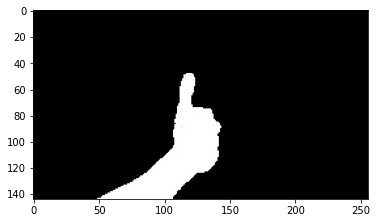

In [121]:
plt.imshow(X_data[0])

### Image Augmentation

In [96]:
import tensorflow as tf
import math
import cv2

orig = X_data[0]
save_to_dir = 'C://Users//clemo//git//motion_identification//model_preparation//augmented_images'

# save original
orig_path = os.path.join(save_to_dir, 'original.jpg')
plt.imsave(orig_path, orig)

# flip image 180 degrees
img = tf.image.rot90(orig)
img = tf.image.rot90(img)
flipped_path = os.path.join(save_to_dir, 'flipped.jpg')
tf.keras.preprocessing.image.save_img(flipped_path, img)

# flip image horizontal and flip resultant image 180 degrees 
from keras.preprocessing.image import ImageDataGenerator
import time

datagen = ImageDataGenerator(horizontal_flip=True)
x = orig.reshape((1,) + orig.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

for img in datagen.flow(x, batch_size=1):
    # mirror image
    img = img.reshape((144,256,3))
    mirrored_path = os.path.join(save_to_dir, 'mirrored.jpg')
    plt.imsave(mirrored_path, img)
   
    # flip mirred image 180 degrees
    img = tf.reshape(img, (144, 256, 3))
    img = tf.image.rot90(img)
    img = tf.image.rot90(img)
    mirrored_flipped_path = os.path.join(save_to_dir, 'mirrored_flipped.jpg')
    tf.keras.preprocessing.image.save_img(mirrored_flipped_path, img)
    break

In [100]:
test = plt.imread(orig_path)
test.shape

(144, 256, 3)

In [ ]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_rgb)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=32),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))

#### Train-test split

In [122]:
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=12, stratify=y_data)

#### Build the VGG Model

In [123]:
input_dir = 'saved_model.hdf5'
# path = join(par_dir, input_dir)
model_checkpoint = ModelCheckpoint(filepath=input_dir, save_best_only=True)

early_stopping = EarlyStopping(monitor='val_accuracy',
                               min_delta=0,
                               patience=10,
                               verbose=1,
                               mode='auto',
                               restore_best_weights=True)

In [149]:
def create_model(height, width):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3)) # topless model

    # Add top
    base = base_model.output
    flat = Flatten()(base)
    fc1 = Dense(128, activation='relu', name='fc1')(flat)
    fc2 = Dense(128, activation='relu', name='fc2')(fc1)
    fc3 = Dense(128, activation='relu', name='fc3')(fc2)
    drop = Dropout(0.5)(fc3)
    fc4 = Dense(64, activation='relu', name='fc4')(drop)
    out = Dense(num_categories, activation='softmax')(fc4)
    model = Model(inputs=base_model.input, outputs=out)

    # Train top layers only
    for layer in base_model.layers:
        layer.trainable = False
    return model

height = X_train.shape[1]
width = X_train.shape[2]
num_categories = y_train.shape[1]
try: 
    assert X_train.shape[3] == 3
except AssertionError:
    print(f'Training data has {X_train.shape[3]} color layers.')
        
model = create_model(height, width)
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [150]:
# fit model
model.fit(X_train, y_train, epochs=3, batch_size=64, validation_split=0.1, verbose=1, callbacks=[early_stopping, model_checkpoint])

Epoch 1/3
29/29 [==============================] - 210s 7s/step - loss: 1.5022 - accuracy: 0.3455 - val_loss: 0.4826 - val_accuracy: 0.8150
Epoch 2/3
29/29 [==============================] - 228s 8s/step - loss: 0.4029 - accuracy: 0.8518 - val_loss: 0.0896 - val_accuracy: 0.9750
Epoch 3/3
29/29 [==============================] - 226s 8s/step - loss: 0.0942 - accuracy: 0.9723 - val_loss: 0.0794 - val_accuracy: 0.9750


In [181]:
model_dir = 'C://Users//clemo//git//motion_identification//motion_identification//models'

import datetime
now = datetime.datetime.now()
date = now.strftime("%Y-%m-%d_T%H_%M")
model_name = date + '_VGG_model.h5'
import os
model_path = os.path.join(model_dir, model_name)
model.save(model_path)

#### Save final model and test import

In [185]:
model_dir = 'C://Users//clemo//git//motion_identification//motion_identification//models'
model_paths = []
for directory, subdirectories, files in os.walk(model_dir):
    for file in files:
        if file[-2:] == 'h5':
            model_path = os.path.join(model_dir, file)
            model_paths.append(model_path)
model_paths
from keras.models import load_model
model2 = load_model(model_paths[0])

#### Get classification metrics

In [206]:
from sklearn.metrics import f1_score
def get_classification_metrics(X_val, y_val):
    pred = model.predict(X_val)
#     pdb.set_trace()
    pred = np.argmax(pred, axis=1)
    y_true = np.argmax(y_val, axis=1)
    print(classification_report(y_true, pred, target_names=['hey', 'you', 'there', 'this', 'is']))
    test = pd.DataFrame(confusion_matrix(y_true, pred), 
             index=['hey', 'you', 'there', 'this', 'is'], columns=['hey', 'you', 'there', 'this', 'is'])
    print(test)
    print(f1_score(y_true, pred, average='micro'))

In [219]:
y_true = np.argmax(y_val, axis=1)
pred = model.predict(X_val)
pred

array([[0.10170583, 0.03374023, 0.19882494, 0.53836167, 0.1273673 ],
       [0.09943277, 0.03823787, 0.20434614, 0.51653033, 0.14145283],
       [0.08349452, 0.02642032, 0.17068663, 0.603272  , 0.11612646],
       ...,
       [0.09820886, 0.03500669, 0.20160364, 0.5267183 , 0.13846244],
       [0.07855569, 0.02161136, 0.14509979, 0.659472  , 0.09526113],
       [0.09034568, 0.03597779, 0.2041334 , 0.5233283 , 0.14621484]],
      dtype=float32)

In [220]:
np.argmax(pred, axis=1)

array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,

**VGG_cross_validated model**

In [207]:
get_classification_metrics(X_val[:50], y_val[:50])

              precision    recall  f1-score   support

         hey       0.00      0.00      0.00         9
         you       0.00      0.00      0.00        10
       there       0.00      0.00      0.00         7
        this       0.24      1.00      0.39        12
          is       0.00      0.00      0.00        12

    accuracy                           0.24        50
   macro avg       0.05      0.20      0.08        50
weighted avg       0.06      0.24      0.09        50

       hey  you  there  this  is
hey      0    0      0     9   0
you      0    0      0    10   0
there    0    0      0     7   0
this     0    0      0    12   0
is       0    0      0    12   0
0.24


c:\users\clemo\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\clemo\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\users\clemo\appdata\local\programs\python\python38\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

#### Predict gesture on a single image

In [ ]:
# path = 'C://Users//clemo//git//motion_identification//model_preparation//2021_02_01_T14_28_23_fist//pure_data//218.jpg'
okay_open_palm = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//176.jpg'
tricky_open_palm = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//397.jpg'
bad_open_palm = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//1606.jpg'
bad_open_palm2 = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//112.jpg'
tricky_open_palm2 = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//695.jpg'
tricky_open_palm3 = 'C://Users//clemo//git//motion_identification//model_preparation//2021_01_29_T19_16_17_open_palm_without_glove//poor_data//1968.jpg'

okay_fist = 'C://Users//clemo//git//motion_identification//model_preparation//2021_02_01_T14_28_23_fist//poor_data//535.jpg'
tricky_open_palm = 'C://Users//clemo//git//motion_identification//model_preparation//2021_02_01_T14_28_23_fist//poor_data//553.jpg'
bad_fist = 'C://Users//clemo//git//motion_identification//model_preparation//2021_02_01_T14_28_23_fist//good_data//1840.jpg'

paths = []
paths.append(okay_open_palm)
paths.append(tricky_open_palm)
paths.append(bad_open_palm)
paths.append(bad_open_palm2)
paths.append(okay_fist)
paths.append(tricky_open_palm)
paths.append(bad_fist)
paths.append(tricky_open_palm2)
paths.append(tricky_open_palm3)

def predict_image(path):
    img = Image.open(path)
    img = np.array(img)
    img = np.array(img, dtype = 'float32')
    img = np.stack((img,)*3, axis=-1) # without comma, (X_data) is np.array not tuple
    pdb.set_trace()
#     img /= 255
    img.resize((1, 144, 256, 3))
    plt.figure()
    plt.imshow(img[0])
    return np.argmax(model2.predict(img))

def load_image(path):
    img = Image.open(path)
    img = np.array(img)
#     img = np.stack((img,)*3, axis=-1) # without comma, (X_data) is np.array not tuple
#     img /= 255
#     plt.figure()
#     plt.imshow(img[0])
    return img

In [ ]:
results = []
for path in paths:
    result = predict_image(path)
    results.append(result)
print(results)

#### Image Augmentation

In [ ]:
# ImageDataGenerator
datagen = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=45,
        width_shift_range=0.2, # horizontal shift
        height_shift_range=0.2, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.2,1.2]) # brightness

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
datagen.fit(X_train_rgb)

# fits the model on batches with real-time data augmentation:
model.fit_generator(datagen.flow(X_train_rgb, y_train_rgb, batch_size=32),
                    steps_per_epoch=len(X_train_rgb) / 128, epochs=10, validation_data=(X_test_rgb, y_test_rgb))